# Updated to S15 to reflect correct numbering in original paper
### Note
* Updated 2025-08-13 to compare Pearson R2 vs. coefficient of determination (R2) from `sklearn.metrics`; appologies to the Instadeep team for the confusion.
* We keep the original `Fig_S11.ipynb` notebook because this reproduces the EXACT figure in the Lotthammer et al paper.

In [1]:
import numpy as np
import matplotlib

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
	
# Set such that PDF fonts export in a manner that they
# are editable in illustrator/affinity
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# set to define axes linewidths
matplotlib.rcParams['axes.linewidth'] = 0.5

# this defines some prefactors so inline figures look nice
# on a retina macbook. These can be commented out without any
# issue and are solely asthetic.
%matplotlib inline
%config InlineBackend.figure_format='retina'

# UPDATE 2020-12-31 (my preferred font is Avenir...)
font = {'family' : 'arial',
    	'weight' : 'normal'}

matplotlib.rc('font', **font)


# for rasterized=True
from matplotlib.backends.backend_pdf import PdfPages

import pandas as pd
from sparrow import Protein
from sklearn.metrics import r2_score




In [2]:
IDRome = pd.read_csv('IDRome_DB.csv')
names = IDRome['seq_name'].to_list()
seqs = IDRome['fasta'].to_list()

In [3]:
from sparrow.predictors import batch_predict

Error importing GPy.
 If trying to run parrot-optimize, make sure to use `pip install idptools-parrot[optimize]`


In [4]:
JML_proteins = {}
for idx in range(len(names)):
    JML_proteins[idx] = Protein(seqs[idx])
    

### Predict Rg for all human IDRs 
The prediction run should take ~3 min on a CPU (or 20-30 seconds on a Macbook pro)

In [5]:
%%time
predictions_rg = batch_predict.batch_predict(JML_proteins, network='scaled_rg')

100%|███████████████████████████████████████████████████████████████| 471/471 [00:16<00:00, 29.09it/s]


CPU times: user 14.9 s, sys: 2.9 s, total: 17.8 s
Wall time: 16.3 s


In [6]:
predictions_re = batch_predict.batch_predict(JML_proteins, network='scaled_re')

100%|███████████████████████████████████████████████████████████████| 471/471 [00:16<00:00, 28.93it/s]


In [7]:
len(predictions_rg)

29998

In [8]:
KLL = {}
JML = {}


names = IDRome['seq_name'].to_list()
seqs = IDRome['fasta'].to_list()
rg = IDRome['Rg/nm'].to_list()
re = IDRome['Ree/nm'].to_list()

# parse and predict seq to ensemble
for idx in range(len(names)):
    
    
    seq = seqs[idx]
    
    
    KLL[names[idx]] = [seqs[idx], 10*rg[idx], 10*re[idx]]
    JML[names[idx]] = [seqs[idx], predictions_rg[idx][1], predictions_re[idx][1]]
    
    

In [9]:
rg_calvados = []
rg_albatross = []
re_calvados = []
re_albatross = []

for n in KLL:
    rg_calvados.append(KLL[n][1])
    rg_albatross.append(JML[n][1])
    re_calvados.append(KLL[n][2])
    re_albatross.append(JML[n][2])

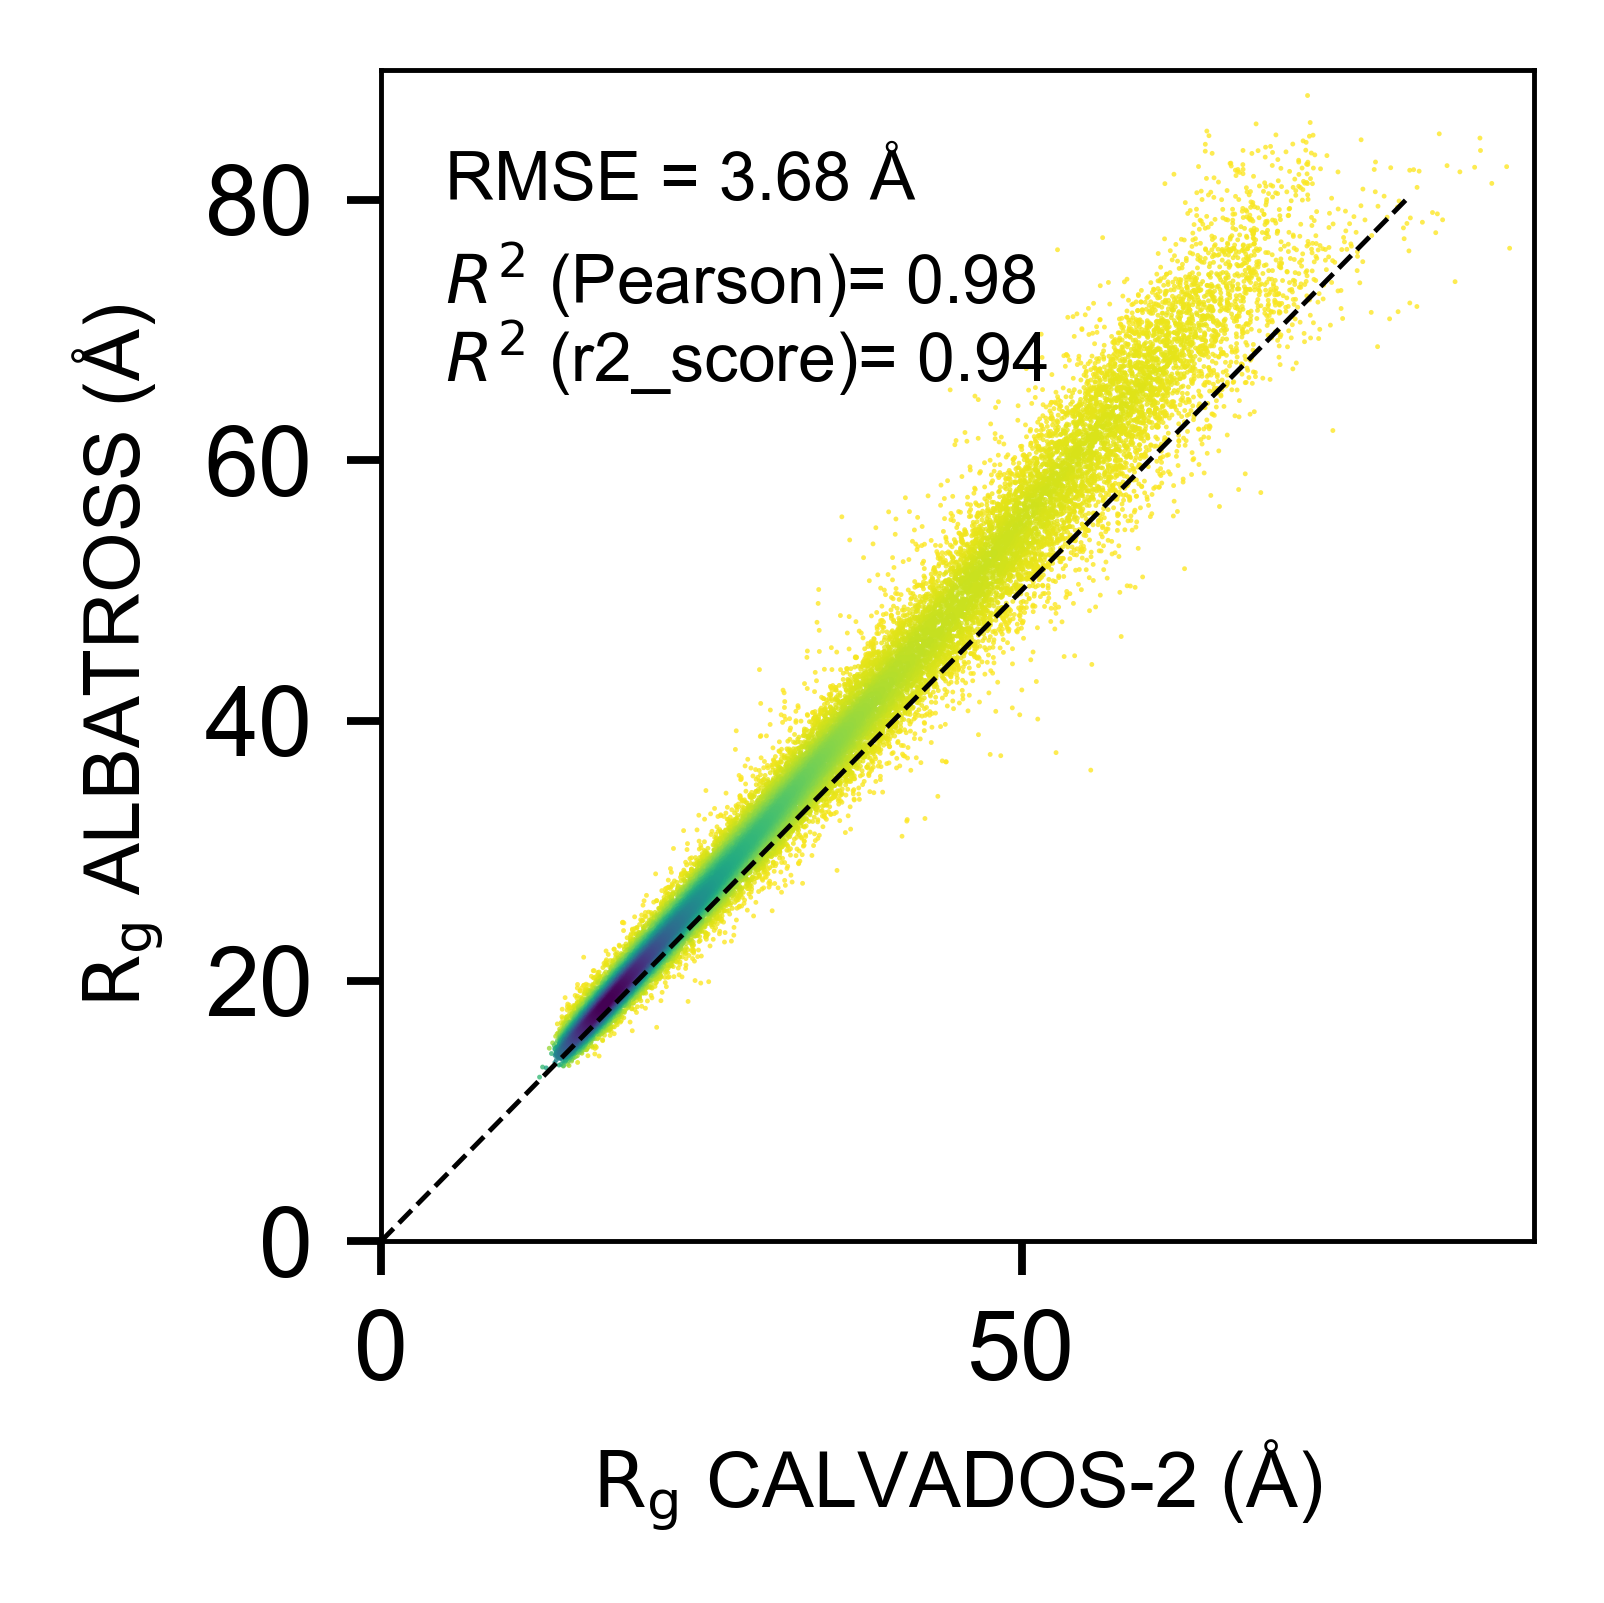

In [20]:
fig = figure(None, (2.4,2.4), dpi=350)

ax = plt.gca()
x = np.array(rg_calvados)
y = np.array(rg_albatross)


def make_gaussian_kde(x, y):
    from scipy.stats import gaussian_kde
    xy = np.vstack([x,y])
    z = gaussian_kde(xy)(xy)
    idx = z.argsort()
    return x[idx], y[idx], z[idx]

# note we overwrite x and y here but it does not change the values
[x,y,z] = make_gaussian_kde(x,y)

# and your plot call would look like:
scatter = ax.scatter(x, y, c=z, cmap='viridis_r', marker='.' , s=1, alpha=0.8,edgecolor='None')

plt.xlim([0,90])
plt.ylim([0,90])
#plt.scatter(np.array(rg1), np.array(rg2), marker='.', alpha=0.5, s=1, c=fp_all, vmin=0, vmax=0.15,edgecolor='None')
RMSE = np.sqrt(np.mean(np.power(np.array(x)-np.array(y),2)))

# Pearson's R2
r2 = np.power(np.corrcoef(x,y)[0][1],2)

# Coefficient of determination
local_r2_score = r2_score(x,y)

plt.plot([0,80],[0,80],'--k',linewidth=0.5)
plt.xlabel(r'$\rm{R_g}$ CALVADOS-2 (Å)', fontsize=8)
plt.ylabel(r'$\rm{R_g}$ ALBATROSS (Å)', fontsize=8)
plt.text(5,80, f"RMSE = {round(RMSE,2)} Å", fontsize=7)
plt.text(5,72, r"$R^2$ (Pearson)" + f"= {round(r2,2)}", fontsize=7)
plt.text(5,66, r"$R^2$ (r2_score)" + f"= {round(local_r2_score,2)}", fontsize=7)
plt.tight_layout()

with PdfPages(f"ALBATROSS_vs_CALVADOS2_new.pdf") as pdf:
    pdf.savefig(fig, dpi=950)  


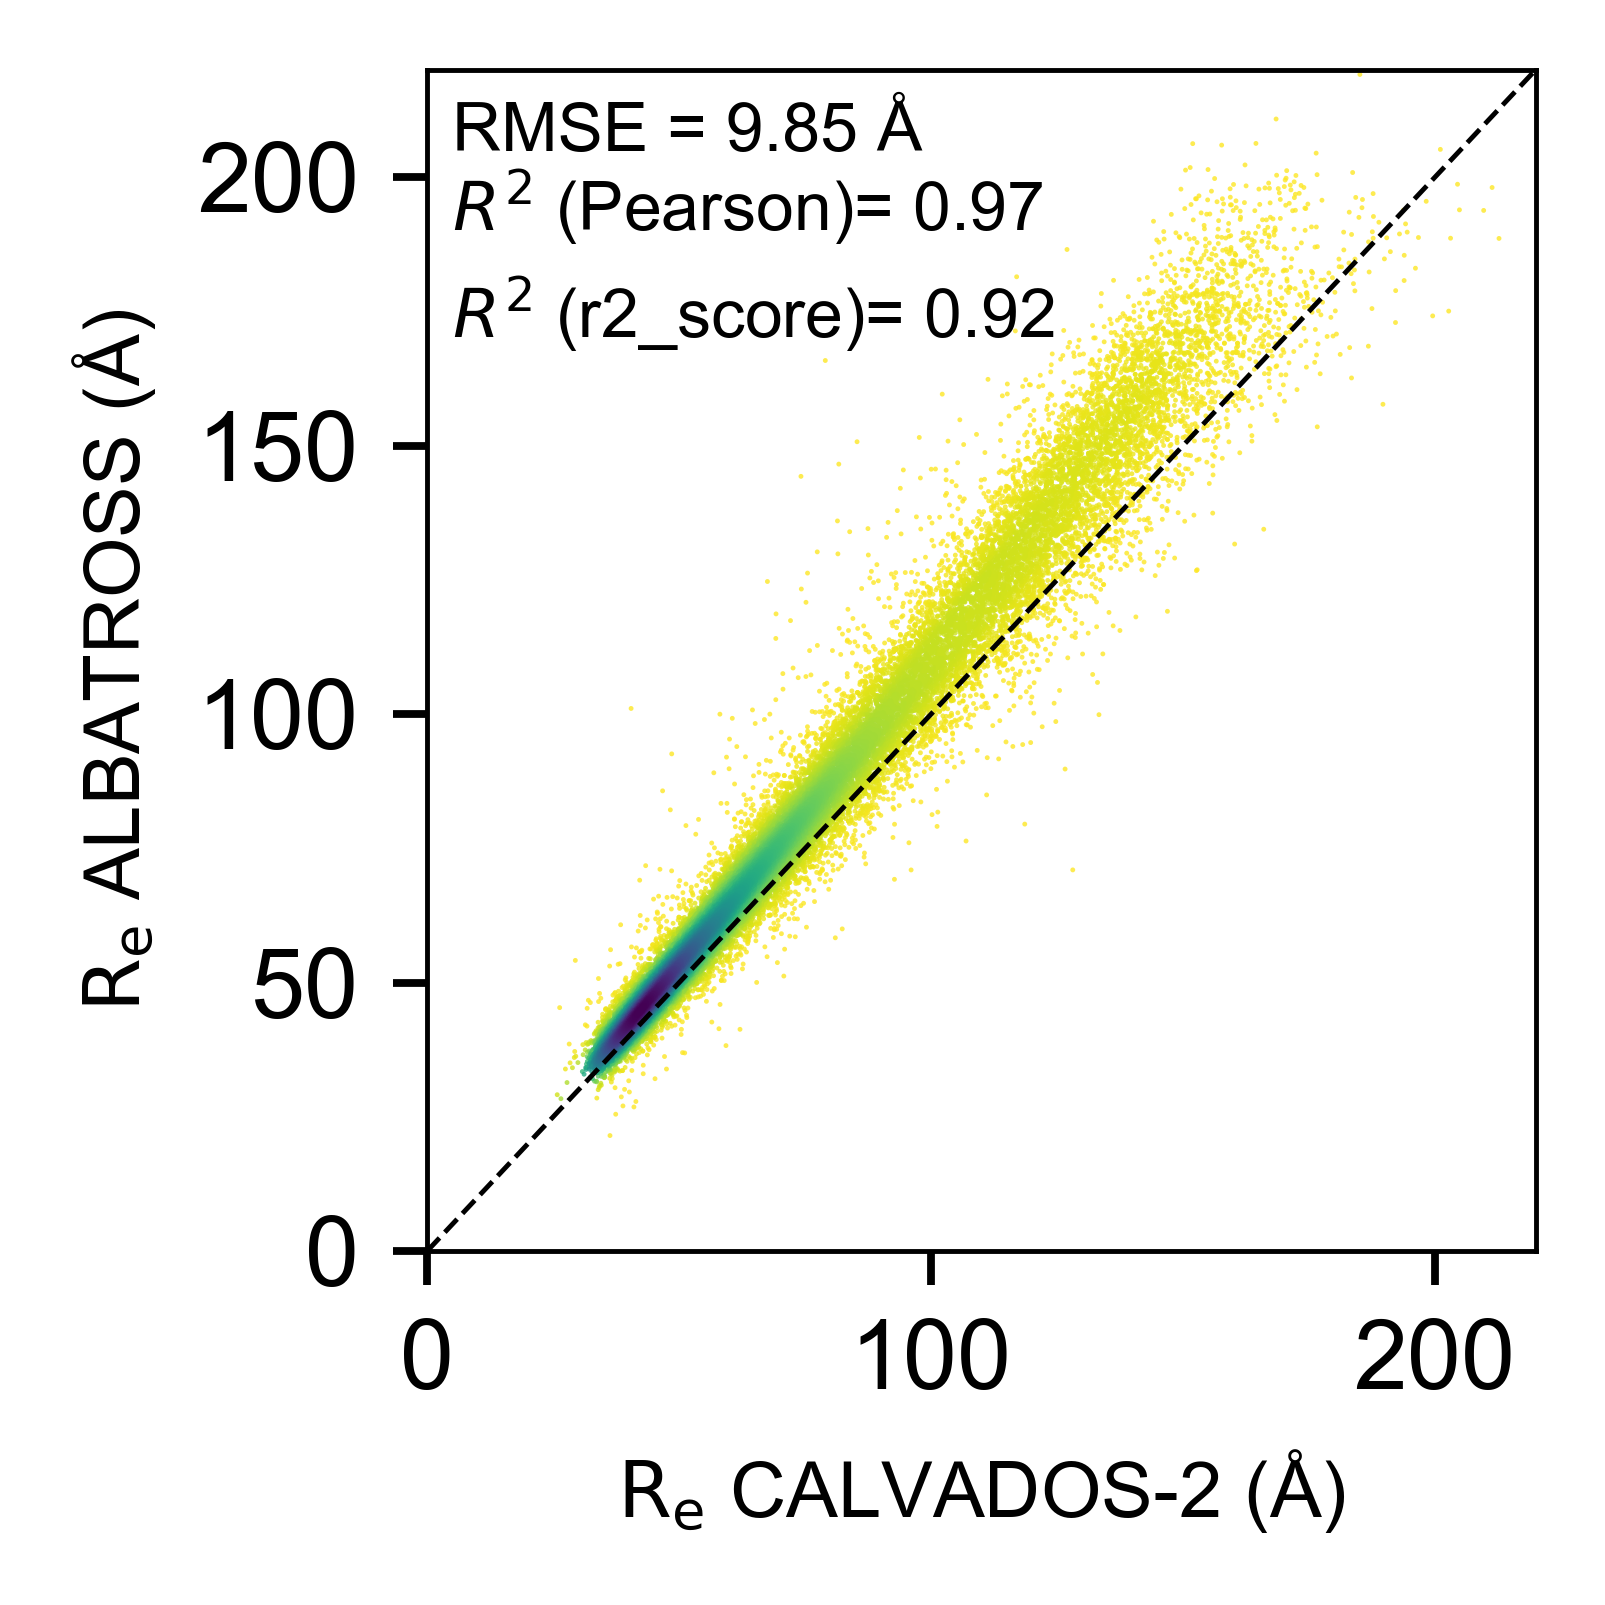

In [19]:
fig = figure(None, (2.4,2.4), dpi=350)

ax = plt.gca()
x = np.array(re_calvados)
y = np.array(re_albatross)


def make_gaussian_kde(x, y):
    from scipy.stats import gaussian_kde
    xy = np.vstack([x,y])
    z = gaussian_kde(xy)(xy)
    idx = z.argsort()
    return x[idx], y[idx], z[idx]


[x,y,z] = make_gaussian_kde(x,y)
# and your plot call would look like:
scatter = ax.scatter(x, y, c=z, cmap='viridis_r', marker='.' , s=1, alpha=0.8,edgecolor='None')

plt.xlim([0, 220])
plt.ylim([0, 220])
#plt.scatter(np.array(rg1), np.array(rg2), marker='.', alpha=0.5, s=1, c=fp_all, vmin=0, vmax=0.15,edgecolor='None')
RMSE = np.sqrt(np.mean(np.power(np.array(x)-np.array(y),2)))


# Pearson's R2
r2 = np.power(np.corrcoef(x,y)[0][1],2)

# Coefficient of determination
local_r2_score = r2_score(x,y)

plt.plot([0, 220], [0, 220],'--k',linewidth=0.5)
plt.xlabel(r'$\rm{R_e}$ CALVADOS-2 (Å)', fontsize=8)
plt.ylabel(r'$\rm{R_e}$ ALBATROSS (Å)', fontsize=8)
plt.text(5,205, f"RMSE = {round(RMSE,2)} Å", fontsize=7)
plt.text(5,190, r"$R^2$ (Pearson)" + f"= {round(r2,2)}", fontsize=7)
plt.text(5,170, r"$R^2$ (r2_score)" + f"= {round(local_r2_score,2)}", fontsize=7)

plt.tight_layout()

with PdfPages(f"ALBATROSS_vs_CALVADOS2_re_new.pdf") as pdf:
    pdf.savefig(fig, dpi=950)  
